In [1]:
# Parameters
DATE = 20211102

In [2]:
model_dir = f"../../models/ml_multilabel_{DATE}"

In [3]:
import os
import pickle

import bento
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from optuna.integration import SkorchPruningCallback
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler
from sklearn.svm import SVC
from skorch import NeuralNet, NeuralNetClassifier
from skorch.callbacks import EarlyStopping, EpochScoring
from xgboost import XGBRFClassifier

# Load training and test data

## Split Data

In [4]:
data = bento.io.read_h5ad("../../data/locfish/locfish_eval_20211019.h5ad")
data.shape

(10000, 1)

In [5]:
# List of features
features = [
    "cell_inner_proximity",
    "nucleus_inner_proximity",
    "nucleus_outer_proximity",
    "cell_inner_asymmetry",
    "nucleus_inner_asymmetry",
    "nucleus_outer_asymmetry",
    "l_max",
    "l_max_gradient",
    "l_min_gradient",
    "l_monotony",
    "l_half_radius",
    "point_dispersion",
    "nucleus_dispersion",
]

cell_by_feature = []
for f in features:
    cell_by_feature.append(data.to_df(f))
cell_by_feature = (
    pd.concat(cell_by_feature, axis=1).reset_index(drop=True).astype(float)
)
cell_by_feature.columns = features

## Prepare datasets

In [6]:
classes = ["cell_edge", "cytoplasmic", "none", "nuclear", "nuclear_edge"]

Split train/test features

In [7]:
X = torch.FloatTensor(cell_by_feature.values)

le = LabelBinarizer().fit(classes)
y = le.transform(data.to_df("pattern").values.flatten())
y = torch.LongTensor(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=22, stratify=y
)

Split train/test image features

In [8]:
from torchvision import datasets, transforms

dataset = datasets.ImageFolder(
    "data/locfish/eval_img",
    transform=transforms.Compose([transforms.Grayscale(), transforms.ToTensor()]),
)
X_img = np.array([x[0].numpy() for x in dataset])
y_img = np.array(dataset.targets)

le = LabelBinarizer().fit(dataset.targets)
y_img = le.transform(y_img)

X_img_train, X_img_test, y_img_train, y_img_test = train_test_split(
    X_img, y_img, train_size=0.8, random_state=22, stratify=y_img
)

# Prepare nn architectures

In [9]:
class FCModule(nn.Module):
    def __init__(
        self,
        l0_size,
        l1_size,
    ):
        super().__init__()
        fc_layers = []
        in_features = 13

        # Hidden layers
        for layer_size in [l0_size, l1_size]:
            fc_layers.extend(
                [
                    nn.Linear(in_features, layer_size),
                    nn.BatchNorm1d(layer_size),
                    nn.Dropout(0.2),
                    nn.ReLU(),
                ]
            )

            in_features = layer_size

        # Output layer
        fc_layers.append(nn.Linear(in_features, 2))
        self.model = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.model(x.float())
        x = F.softmax(x, dim=-1)
        return x

In [10]:
def get_conv_dim(in_size, padding, dilation, kernel_size, stride):
    outsize = 1 + (in_size + 2 * padding - dilation * (kernel_size - 1) - 1) / stride
    return int(outsize)


class SpotsBinaryModule(nn.Module):
    def __init__(
        self,
        n_conv_layers,
        in_dim,
        out_channels,
        kernel_size,
        f_units_l0,
        f_units_l1,
    ) -> None:
        super().__init__()
        conv_layers = []

        in_channels = 1
        in_dim = in_dim

        # Stack (convolutions + batchnorm + activation) + maxpool
        for i in range(n_conv_layers):
            conv_layers.extend(
                [
                    nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=kernel_size,
                    ),
                    nn.BatchNorm2d(out_channels),
                    nn.Dropout(0.2),
                    nn.ReLU(),
                ]
            )

            # Compute convolved output dimensions
            in_dim = get_conv_dim(
                in_dim, padding=0, dilation=1, kernel_size=kernel_size, stride=1
            )

            in_channels = out_channels
            out_channels *= 2

        out_channels = int(out_channels / 2)

        conv_layers.append(nn.MaxPool2d(2, 2))
        in_dim = int(in_dim / 2)

        # We optimize the number of layers, hidden units and dropout ratio in each layer.
        fc_layers = [nn.Flatten()]

        # Compute flatten size
        in_features = out_channels * in_dim * in_dim
        for i in [f_units_l0, f_units_l1]:
            out_features = i
            fc_layers.extend(
                [
                    nn.Linear(in_features, out_features),
                    nn.BatchNorm1d(out_features),
                    nn.Dropout(0.2),
                    nn.ReLU(),
                ]
            )

            in_features = out_features

        fc_layers.append(nn.Linear(in_features, 2))
        self.model = torch.nn.Sequential(*[*conv_layers, *fc_layers])

    def forward(self, x):
        x = self.model(x)
        x = F.softmax(x, dim=-1)
        return x

# Hyperparameters Optimization Performance

## Gradient-boosted Random Forest

In [117]:
rf_study = optuna.load_study(
    study_name=f"xgbrf",
    storage=f"sqlite:///{model_dir}/optuna.db",
)

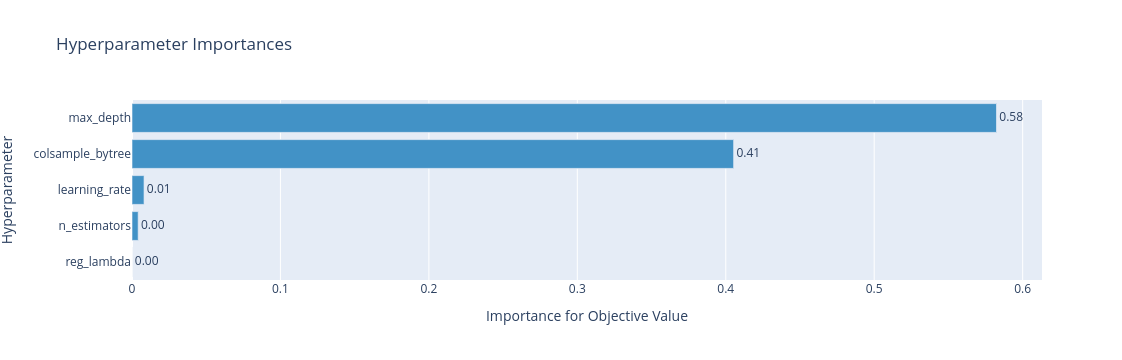

In [118]:
optuna.visualization.plot_param_importances(rf_study)

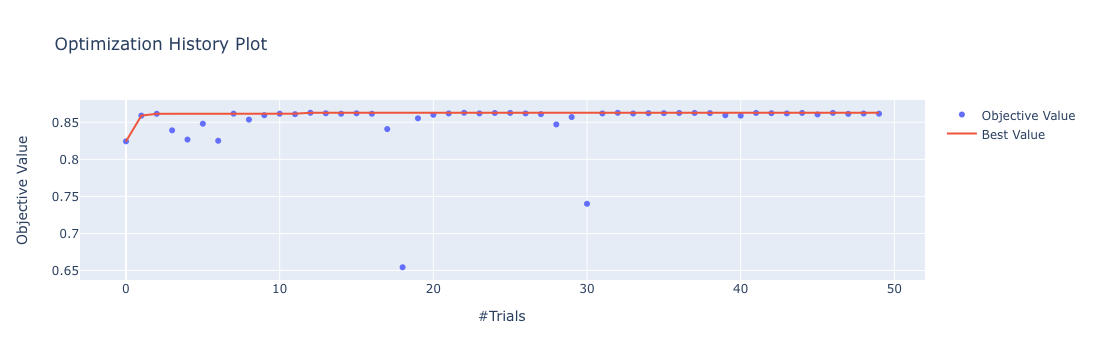

In [119]:
optuna.visualization.plot_optimization_history(rf_study)

## Support Vector Classifier

In [120]:
svc_study = optuna.load_study(
    study_name=f"svc",
    storage=f"sqlite:///{model_dir}/optuna.db",
)

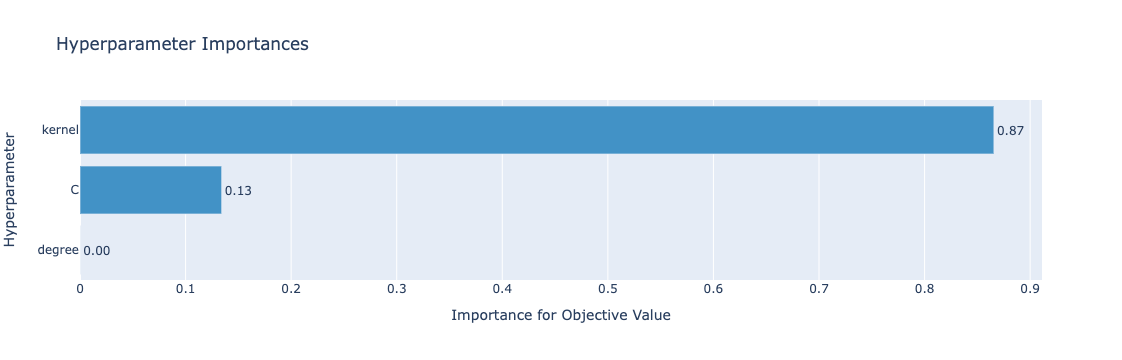

In [121]:
optuna.visualization.plot_param_importances(svc_study)

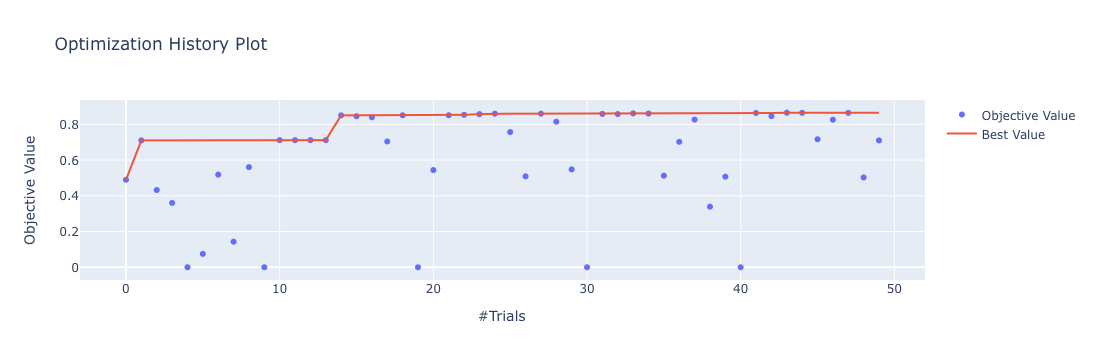

In [122]:
optuna.visualization.plot_optimization_history(svc_study)

## Feed Forward Neural Net

In [123]:
nn_study = optuna.load_study(
    study_name=f"ffnn",
    storage=f"sqlite:///{model_dir}/optuna.db",
)

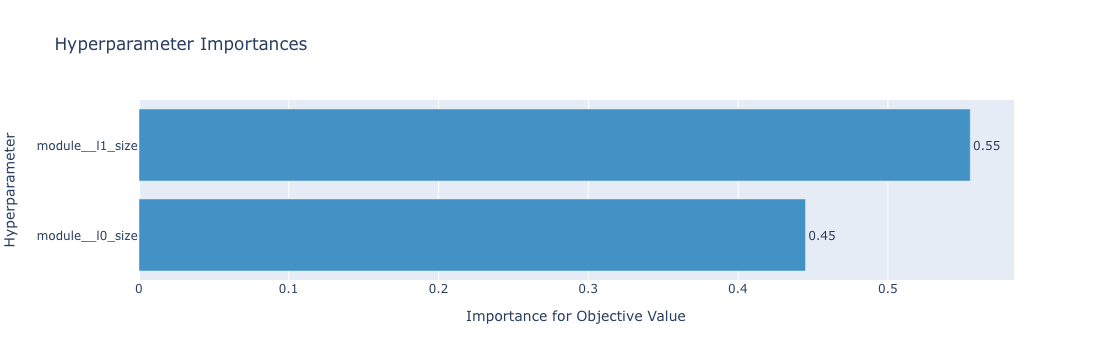

In [124]:
optuna.visualization.plot_param_importances(nn_study)

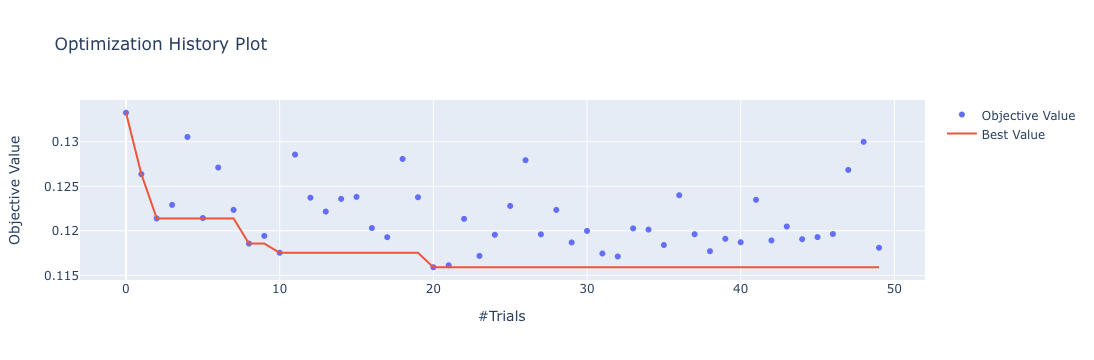

In [125]:
optuna.visualization.plot_optimization_history(nn_study)

## CNN Neural Net

In [126]:
cnn_study = optuna.load_study(
    study_name="cnn",
    storage=f"sqlite:///{model_dir}/optuna.db",
)

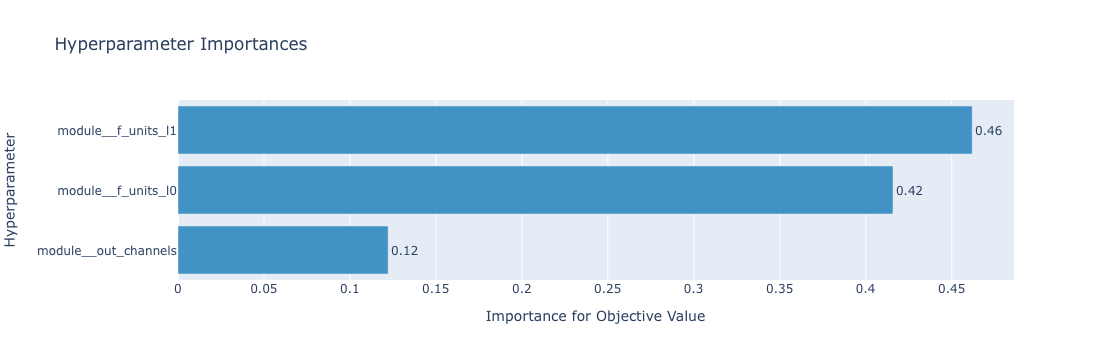

In [127]:
optuna.visualization.plot_param_importances(cnn_study)

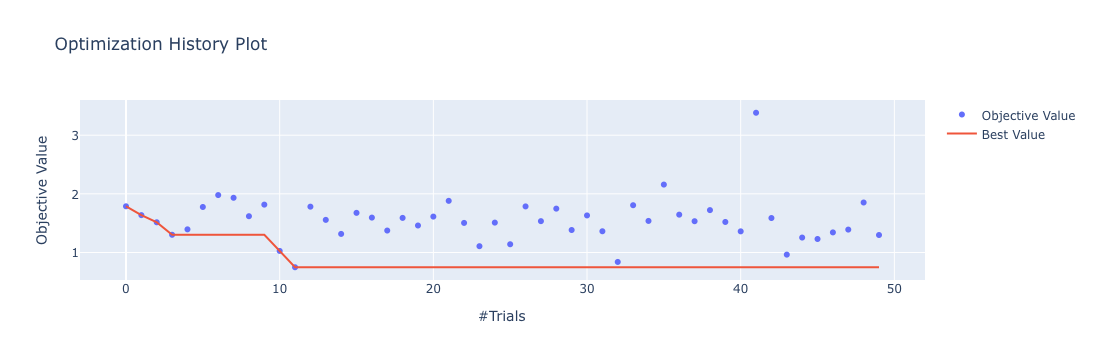

In [128]:
optuna.visualization.plot_optimization_history(cnn_study)

# Compute Test Performance

Load models

In [11]:
rf_model = pickle.load(open(f"{model_dir}/rf_model.pkl", "rb"))
svc_model = pickle.load(open(f"{model_dir}/svc_model.pkl", "rb"))
nn_model = pickle.load(open(f"{model_dir}/nn_model.pkl", "rb"))
cnn_model = pickle.load(open(f"{model_dir}/cnn_model.pkl", "rb"))

classifiers = [rf_model, svc_model, nn_model, cnn_model]
classifier_names = ["Random Forest", "SVM", "NN", "CNN"]

In [12]:
from torchinfo import summary

In [26]:
summary(nn_model.estimators_[0]['neuralnetclassifier'].module_, input_size=(100, 13))

Layer (type:depth-idx)                   Output Shape              Param #
FCModule                                 --                        --
├─Sequential: 1-1                        [100, 2]                  --
│    └─Linear: 2-1                       [100, 88]                 1,232
│    └─BatchNorm1d: 2-2                  [100, 88]                 176
│    └─Dropout: 2-3                      [100, 88]                 --
│    └─ReLU: 2-4                         [100, 88]                 --
│    └─Linear: 2-5                       [100, 15]                 1,335
│    └─BatchNorm1d: 2-6                  [100, 15]                 30
│    └─Dropout: 2-7                      [100, 15]                 --
│    └─ReLU: 2-8                         [100, 15]                 --
│    └─Linear: 2-9                       [100, 2]                  32
Total params: 2,805
Trainable params: 2,805
Non-trainable params: 0
Total mult-adds (M): 0.28
Input size (MB): 0.01
Forward/backward pass size (MB):

In [37]:
summary(cnn_model.estimators_[0].module_, input_size=(100, 1, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
SpotsBinaryModule                        --                        --
├─Sequential: 1-1                        [100, 2]                  --
│    └─Conv2d: 2-1                       [100, 2, 62, 62]          20
│    └─BatchNorm2d: 2-2                  [100, 2, 62, 62]          4
│    └─Dropout: 2-3                      [100, 2, 62, 62]          --
│    └─ReLU: 2-4                         [100, 2, 62, 62]          --
│    └─Conv2d: 2-5                       [100, 4, 60, 60]          76
│    └─BatchNorm2d: 2-6                  [100, 4, 60, 60]          8
│    └─Dropout: 2-7                      [100, 4, 60, 60]          --
│    └─ReLU: 2-8                         [100, 4, 60, 60]          --
│    └─MaxPool2d: 2-9                    [100, 4, 30, 30]          --
│    └─Flatten: 2-10                     [100, 3600]               --
│    └─Linear: 2-11                      [100, 13]                 46,813
│    └─BatchN

Make test predictions

In [12]:
predict = []
predict.append(rf_model.predict_proba(X_test.numpy()))
predict.append(svc_model.predict_proba(X_test.numpy()))
predict.append(nn_model.predict_proba(X_test))
predict.append(cnn_model.predict_proba(X_img_test))

## AUCs

In [13]:
from sklearn.metrics import auc, roc_curve

fpr = dict()
tpr = dict()
roc_auc = dict()

for c, cname, pred in zip(classifiers, classifier_names, predict):
    fpr[cname] = dict()
    tpr[cname] = dict()
    roc_auc[cname] = dict()

    # Overall scores
    fpr[cname]["all"], tpr[cname]["all"], _ = roc_curve(y_test.ravel(), pred.ravel())
    roc_auc[cname]["all"] = auc(fpr[cname]["all"], tpr[cname]["all"])

    # Class specific scores
    for i in range(len(classes)):
        fpr[cname][i], tpr[cname][i], _ = roc_curve(y_test[:, i], pred[:, i])
        roc_auc[cname][i] = auc(fpr[cname][i], tpr[cname][i])

### Overall ROC curves

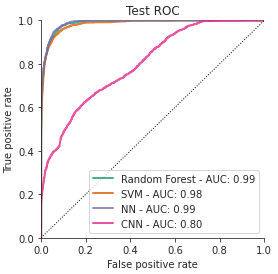

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

with sns.axes_style("ticks"):
    plt.figure(figsize=(4, 4))

    colors = sns.color_palette("Dark2", n_colors=len(classifier_names))
    for cname, color in zip(classifier_names, colors):
        plt.plot(
            fpr[cname]["all"],
            tpr[cname]["all"],
            label=f"{cname} - AUC: {roc_auc[cname]['all']:0.2f}",
            color=color,
            linestyle="-",
            linewidth=2,
            alpha=0.8
        )
    plt.plot([0, 1], [0, 1], ":", c="black", lw=1)

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("Test ROC")
    plt.legend(loc="lower right")
    sns.despine()
    rc = {'svg.fonttype': 'none', 'font.family':'Arial'}
    with plt.rc_context(rc):
        plt.savefig('figures/preprint/fig2_models_roc.svg', dpi=100)

### Class-specific ROC curves

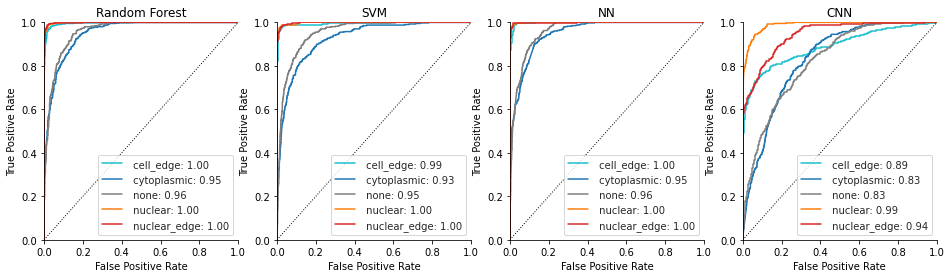

In [30]:
fig, axes = plt.subplots(1, len(classifiers), figsize=(16,4))
for cname, ax in zip(classifier_names, axes):
    with sns.axes_style("ticks"):

        colors = bento._utils.PATTERN_COLORS
        for i, color in zip(range(len(classes)), colors):
            ax.plot(
                fpr[cname][i],
                tpr[cname][i],
                color=color,
                lw=1.5,
                label=" {0}: {1:0.2f}"
                "".format(dataset.classes[i], roc_auc[cname][i]),
            )

        ax.plot([0, 1], [0, 1], "k:", lw=1)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(cname)
        ax.legend(loc="lower right")
        sns.despine()
        
rc = {'svg.fonttype': 'none', 'font.family':'Arial'}
with plt.rc_context(rc):
    plt.savefig('figures/preprint/fig2_classwise_roc.svg', dpi=100)

# Precision Recall

In [134]:
from sklearn.metrics import (
    PrecisionRecallDisplay,
    average_precision_score,
    precision_recall_curve,
)

# For each class
precision = dict()
recall = dict()
average_precision = dict()

for c, cname, pred in zip(classifiers, classifier_names, predict):
    precision[cname] = dict()
    recall[cname] = dict()
    average_precision[cname] = dict()
    for i in range(len(classes)):
        precision[cname][i], recall[cname][i], _ = precision_recall_curve(
            y_test[:, i], pred[:, i]
        )
        average_precision[cname][i] = average_precision_score(y_test[:, i], pred[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision[cname]["micro"], recall[cname]["micro"], _ = precision_recall_curve(
        y_test.ravel(), pred.ravel()
    )
    average_precision[cname]["micro"] = average_precision_score(
        y_test, pred, average="micro"
    )

## Overall Precision-Recall curves

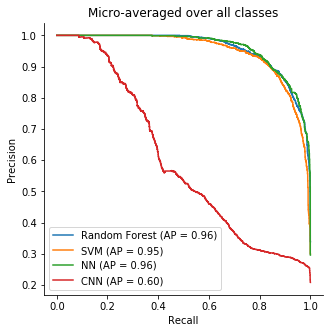

In [135]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for cname in classifier_names:
    display = PrecisionRecallDisplay(
        recall=recall[cname]["micro"],
        precision=precision[cname]["micro"],
        average_precision=average_precision[cname]["micro"],
    )
    display.plot(ax=ax, name=cname)
    _ = display.ax_.set_title("Micro-averaged over all classes")

sns.despine()

## Class-specific Precision-Recall curves

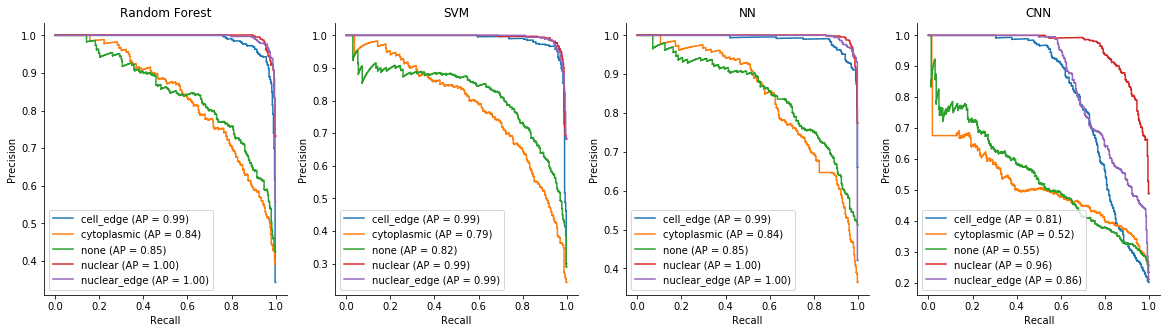

In [144]:
fig, axes = plt.subplots(1, len(classifiers), figsize=(20, 5))
for cname, ax in zip(classifier_names, axes):

    for i, color in zip(range(len(classes)), colors):
        display = PrecisionRecallDisplay(
            recall=recall[cname][i],
            precision=precision[cname][i],
            average_precision=average_precision[cname][i],
        )
        display.plot(ax=ax, name=f"{dataset.classes[i]}", color=color)
        ax.set_title(cname)
    sns.despine()